In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from itertools import combinations 
from scipy.cluster import hierarchy
#import matplotlib.style
import matplotlib as mpl
import string
#import pingouin as pg
import matplotlib.cm as cm
#import pymannkendall 
from matplotlib.ticker import FuncFormatter

mplDefaultParams = mpl.rcParams

In [3]:
outputFig = False

## Simulated data

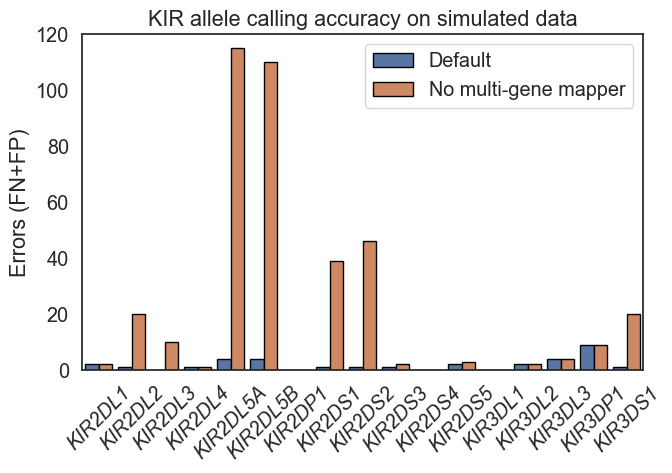

In [4]:
# gene color
fp = open("data/KIR_1000Genome/eval_exon_gene.out")
kirList = []
for line in fp:
    cols = line.rstrip().split()
    if ("KIR" not in cols[0]):
        continue
    kirList.append(cols[0])
fp.close()

# default
errorCount = {}
fp = open("data/sim/eval.out")
for line in fp:
    if (line[0] != "F"):
        continue
    gene = line.split()[1].split("*")[0]
    if (gene not in errorCount):
        errorCount[gene] = 0
    errorCount[gene] += 1
fp.close()
methodv = []
kirv = []
errorv = []
for k in kirList:
    kirv.append(k)
    methodv.append("Default")
    if (k in errorCount):
        errorv.append(errorCount[k])
    else:
        errorv.append(0)
    
# No multi-gene mapper
errorCount = {}
fp = open("data/sim/eval_nocrossgene.out")
for line in fp:
    if (line[0] != "F"):
        continue
    gene = line.split()[1].split("*")[0]
    if (gene not in errorCount):
        errorCount[gene] = 0
    errorCount[gene] += 1
fp.close()
for k in kirList:
    kirv.append(k)
    methodv.append("No multi-gene mapper")
    if (k in errorCount):
        errorv.append(errorCount[k])
    else:
        errorv.append(0)

df = pd.DataFrame({"Method":methodv, "Error":errorv, "Gene":kirv})
fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style="white", font_scale=1.3)
snsFig = sns.barplot(x="Gene", y="Error", hue="Method", data=df, order=kirList,
                    edgecolor="black")
handles, labels = snsFig.get_legend_handles_labels()
#snsFig = sns.boxplot(x="Gene", y="Error", hue="Method", data=df, order=kirList)
#snsFig = sns.stripplot(x="Gene", y="Error", hue="Method", data=df, order=kirList, dodge=True)
snsFig.set_xticklabels(snsFig.get_xticklabels(), rotation = 45, style="italic")
snsFig.set(xlabel="")
snsFig.legend()
#snsFig.legend(handles, labels, loc="upper right")
snsFig.set(ylim=(-0.02,120), title="KIR allele calling accuracy on simulated data",
          ylabel="Errors (FN+FP)")
plt.tight_layout()
if (outputFig):
    plt.savefig("KIR_sim.pdf", format="pdf")

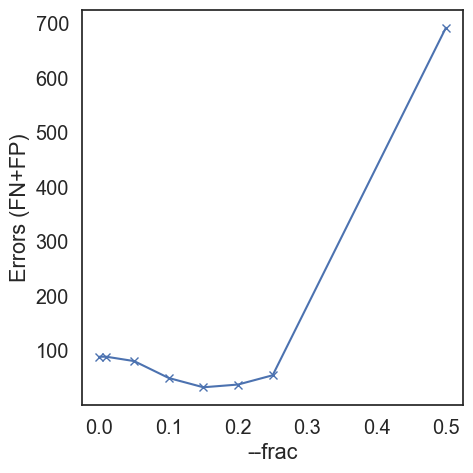

In [5]:
# Supplementary figure: varying the threshold 
x = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]
y = [89, 89, 81, 50, 33, 38, 55, 692]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y, "bx-")
ax.set(ylabel="Errors (FN+FP)", xlabel="--frac")
plt.tight_layout()
if (outputFig):
    plt.savefig("supp_KIR_sim_vary_frac.png", dpi=300)

## KIR genotype validated with phased asssemblies

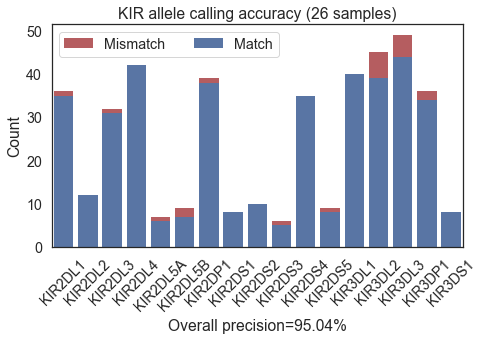

In [47]:
# Outdated
fp = open("data/KIR_1000Genome/eval_exon_gene.out")
geneInfo = {}
genev = []
precv = []
tpv = []
fpv = []
pv = []
for line in fp:
    cols = line.rstrip().split()
    gene = cols[0]
    geneInfo[gene] = {}
    geneInfo[gene]["Precision"] = float(cols[1])
    geneInfo[gene]["P"] = int(cols[3])
    geneInfo[gene]["FP"] = int(cols[5])
    genev.append(gene)
    precv.append(float(cols[1]))
    tpv.append(int(cols[3]))
    fpv.append(int(cols[5]))
    pv.append(int(cols[3]) + int(cols[5]))
fp.close()

df = pd.DataFrame()
df["Gene"] = genev
df["Precision"] = precv
df["TP"] = tpv
df["FP"] = fpv
df["P"] = pv

subdf = df.loc[df["Gene"]!="Overall"]
fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style="white", font_scale=1.3)
snsFig = sns.barplot(x="Gene", y="P", data=subdf, color=sns.color_palette()[3], 
                     label="Mismatch", ax=ax, linewidth=0)
sns.barplot(x="Gene", y="TP", data=subdf, color=sns.color_palette()[0], ax=snsFig, label="Match",
           linewidth=0)
snsFig.set(ylabel="Count", xlabel="Overall precision=95.04%", title="KIR allele calling accuracy (26 samples)")
snsFig.set_xticklabels(snsFig.get_xticklabels(),rotation = 45)
snsFig.legend(loc='upper left', ncol=2)

plt.tight_layout()
if (outputFig):
    #plt.savefig("eval_exon_gene.png", dpi=300)
    plt.savefig("KIR_HPRC_exon_gene.pdf", format="pdf")

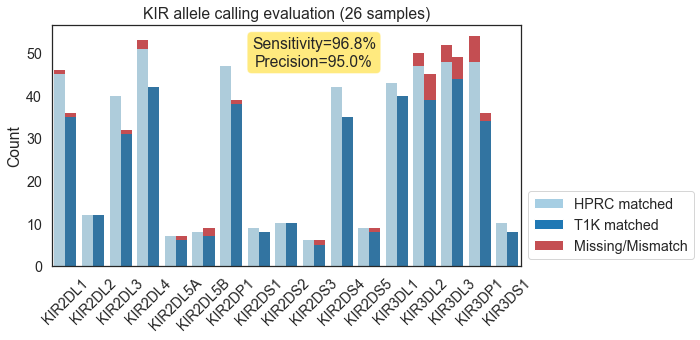

In [14]:
# HPRC: recall and precision on the same figure.
fp = open("data/KIR_1000Genome/eval_exon_gene.out")
geneInfo = {}
genev = []
matchv = []
totalv = []
typev = [] # "T1K, Truth"
for line in fp:
    cols = line.rstrip().split()
    gene = cols[0]
    geneInfo[gene] = {}
    geneInfo[gene]["Precision"] = float(cols[1])
    geneInfo[gene]["TP"] = int(cols[3])
    geneInfo[gene]["P"] = int(cols[3]) + int(cols[5])
fp.close()

fp = open("data/KIR_1000Genome/eval_recall_gene.out")
for line in fp:
    cols = line.rstrip().split()
    gene= cols[0]
    geneInfo[gene]["Recall"] = float(cols[1])
    geneInfo[gene]["T"] = int(cols[3]) + int(cols[5])
    geneInfo[gene]["T_match"] = int(cols[3])
fp.close()

for gene in sorted(geneInfo.keys()):
    genev.append(gene)
    matchv.append(geneInfo[gene]["TP"])
    totalv.append(geneInfo[gene]["P"])
    typev.append("T1K")
    genev.append(gene)
    matchv.append(geneInfo[gene]["T_match"])
    totalv.append(geneInfo[gene]["T"])
    typev.append("Truth")
    
df = pd.DataFrame()
df["Gene"] = genev
df["Match"] = matchv
df["Total"] = totalv
df["Type"] = typev

subdf = df.loc[df["Gene"]!="Overall"]
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="white", font_scale=1.3)
snsFig = sns.barplot(x="Gene", y="Total", data=subdf, hue="Type", 
                     hue_order=["Truth", "T1K"], ax=ax)
usedPatches = 0
for i, patch in enumerate(snsFig.patches):
    patch.set_facecolor(sns.color_palette()[3])
    patch.set(edgecolor="white", linewidth=0)
    usedPatches = i
    
snsFig = sns.barplot(x="Gene", y="Match", data=subdf, hue="Type",
                    hue_order=["Truth", "T1K"], ax=ax, palette="Paired")
snsFig.text(x=9, y=47, s="Sensitivity=96.8%\nPrecision=95.0%", ha="center",
           bbox=dict(boxstyle='round', facecolor='gold', alpha=0.5))
usedPatches = 0
for i, patch in enumerate(snsFig.patches):
    #patch.set_facecolor(sns.color_palette()[3])
    if (i < usedPatches):
        continue
    patch.set(edgecolor="white", linewidth=0)

legend_elements = [mpatches.Patch(facecolor=sns.color_palette("Paired")[0],
                         label='HPRC matched'),
                   mpatches.Patch(facecolor=sns.color_palette("Paired")[1],
                         label='T1K matched'),
                    mpatches.Patch(facecolor=sns.color_palette()[3],
                         label='Missing/Mismatch')]
snsFig.set(ylabel="Count", xlabel="", 
           title="KIR allele calling evaluation (26 samples)")
snsFig.set_xticklabels(snsFig.get_xticklabels(),rotation = 45)
snsFig.legend(handles=legend_elements, loc='lower left', ncol=1,
             bbox_to_anchor=(1,0))

plt.tight_layout()
plt.savefig("KIR_HPRC_exon_gene.pdf", format="pdf")

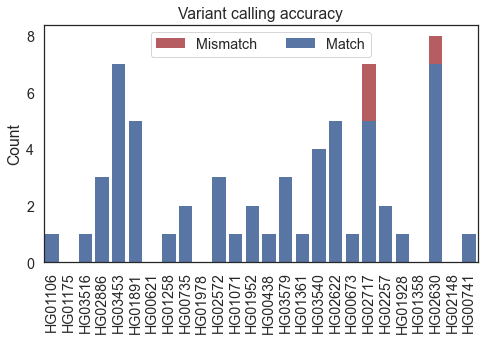

In [6]:
# variant calling result
fp = open("data/KIR_1000Genome/eval_vcf.out")
samplev = []
tpv = []
pv = []
precv = []
for line in fp:
    cols = line.rstrip().split()
    sample = cols[0]
    samplev.append(sample)
    tpv.append(int(cols[1]))
    pv.append(int(cols[2]))
    precv.append(float(cols[3]))
fp.close()

df = pd.DataFrame()
df["Sample"] = samplev
df["Precision"] = precv
df["TP"] = tpv
df["P"] = pv

subdf = df.loc[df["Sample"]!="Overall"]
fig, ax = plt.subplots(figsize=(7, 5))
snsFig = sns.barplot(x="Sample", y="P", data=subdf, color=sns.color_palette()[3], 
                     label="Mismatch", ax=ax, linewidth=0)
sns.barplot(x="Sample", y="TP", data=subdf, color=sns.color_palette()[0], ax=snsFig, 
            label="Match", linewidth=0)
snsFig.set(ylabel="Count", xlabel="Sample\nOverall precision=95.00%", 
           title="Variant calling accuracy")
snsFig.set_xticklabels(snsFig.get_xticklabels(),rotation = 90)
snsFig.set(xlabel="")
snsFig.legend(loc='upper center', ncol=2)

plt.tight_layout()
if (outputFig):
    plt.savefig("KIR_HPRC_exon_gene_vcf.png", dpi=300)
    #plt.savefig("KIR_HPRC_exon_gene_vcf.pdf", format="pdf")

## HLA - 1000 Genome RNA-seq and WES 

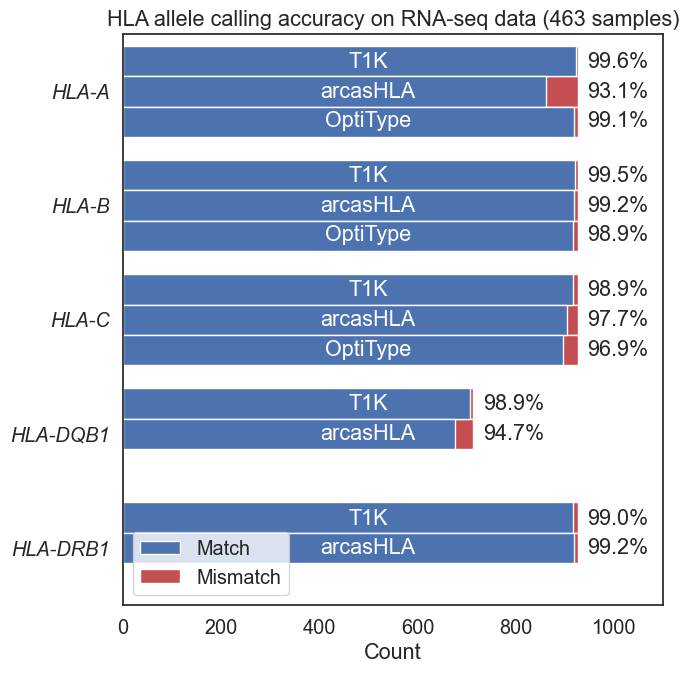

In [6]:
# RNA-seq
geneOrder = ["HLA-A", "HLA-B", "HLA-C", "HLA-DQB1", "HLA-DRB1"]
methods = ["T1K", "arcasHLA", "OptiType"]
methodv = []
genev = []
precv = []
tpv = []
tfpv = []
for method in methods:
    fp = open("data/HLA_1000Genome/" + method + "_RNAseq_HLA.tsv")
    for line in fp:
        cols = line.rstrip().split()
        gene = cols[0]
        if (gene not in geneOrder):
            continue
        methodv.append(method)
        genev.append(gene)
        precv.append(float(cols[1]))
        tpv.append(int(cols[3]))
        tfpv.append(int(cols[3]) + int(cols[5]))
    fp.close()

df = pd.DataFrame()
df["Gene"] = genev
df["Method"] = methodv
df["Precision"] = precv
df["TP"] = tpv
df["TFP"] = tfpv

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(style="white", font_scale=1.3)
snsFig = sns.barplot(y="Gene", x="TFP", data=df, order=geneOrder,
                     hue="Method", ax=ax, orient="h", hue_order = methods)
i = 0
used = 0
for i, patch in enumerate(snsFig.patches):
    patch.set_facecolor(sns.color_palette()[3])
    patch.set_edgecolor("white")
    used = i
sns.barplot(y="Gene", x="TP", hue="Method", order=geneOrder,
            data=df, ax=snsFig, orient="h", hue_order=methods)
i = 0
for i, patch in enumerate(snsFig.patches):
    if (i <= used):
        continue
    patch.set_facecolor(sns.color_palette()[0])
    patch.set_edgecolor("white")

#snsFig.set_xticklabels(snsFig.get_xticklabels(),rotation = 90)
legend_elements = [mpatches.Patch(facecolor=sns.color_palette()[0],
                         label='Match'),
                    mpatches.Patch(facecolor=sns.color_palette()[3],
                         label='Mismatch')]

snsFig.set_yticklabels(snsFig.get_yticklabels(), style="italic")

x=940
for y in range(len(geneOrder)):
    for i, method in enumerate(methods):
        subdf = df.loc[(df["Gene"]==geneOrder[y]) &
                                       (df["Method"] == method)]
        if (len(subdf) == 0):
            continue
        accuracy = float(subdf["Precision"])
        snsFig.text(x=500, y=y + 0.26 * (i - 1), s=method, va="center", ha="center",
                   color="white")
        snsFig.text(x=subdf["TFP"]+20, y=y + 0.26 * (i - 1), s="%.1f"%(accuracy*100) + "%",
                   va="center", ha="left")
snsFig.legend(handles=legend_elements, loc="lower left")
snsFig.set(xlim=(0,1100), ylabel="", xlabel="Count",
           title="HLA allele calling accuracy on RNA-seq data (463 samples)")

plt.tight_layout()
if (outputFig):
    #plt.savefig("eval_hla.png", dpi=300)
    plt.savefig("HLA_1KG_RNAseq.pdf", format="pdf")


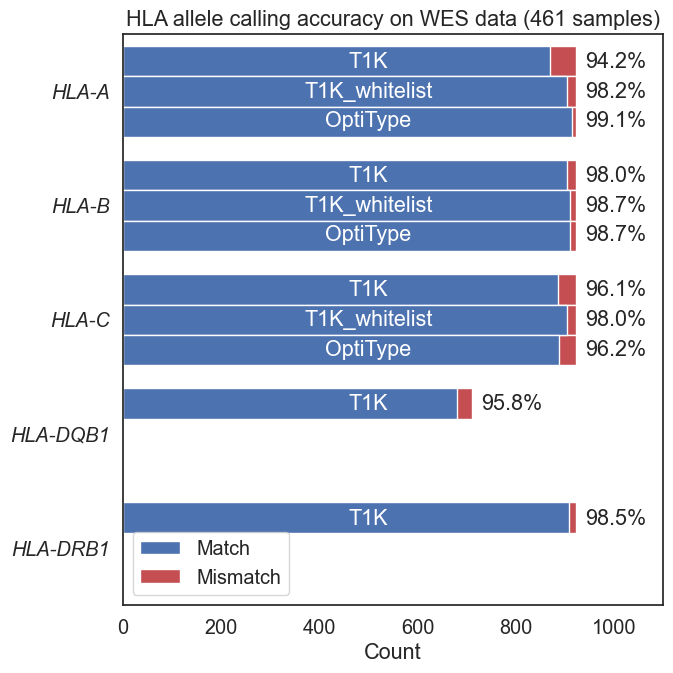

In [7]:
# WES
geneOrder = ["HLA-A", "HLA-B", "HLA-C", "HLA-DQB1", "HLA-DRB1"]
methods = ["T1K", "T1K_whitelist", "OptiType"]
methodv = []
genev = []
precv = []
tpv = []
tfpv = []
for method in methods:
    fp = open("data/HLA_1000Genome/" + method + "_WES_HLA.tsv")
    for line in fp:
        cols = line.rstrip().split()
        gene = cols[0]
        if (gene not in geneOrder):
            continue
        methodv.append(method)
        genev.append(gene)
        precv.append(float(cols[1]))
        tpv.append(int(cols[3]))
        tfpv.append(int(cols[3]) + int(cols[5]))
    fp.close()

df = pd.DataFrame()
df["Gene"] = genev
df["Method"] = methodv
df["Precision"] = precv
df["TP"] = tpv
df["TFP"] = tfpv

fig, ax = plt.subplots(figsize=(7, 7))
sns.set(style="white", font_scale=1.3)
snsFig = sns.barplot(y="Gene", x="TFP", data=df, order=geneOrder,
                     hue="Method", ax=ax, orient="h", hue_order = methods)
i = 0
used = 0
for i, patch in enumerate(snsFig.patches):
    patch.set_facecolor(sns.color_palette()[3])
    patch.set_edgecolor("white")
    used = i
sns.barplot(y="Gene", x="TP", hue="Method", order=geneOrder,
            data=df, ax=snsFig, orient="h", hue_order=methods)
i = 0
for i, patch in enumerate(snsFig.patches):
    if (i <= used):
        continue
    patch.set_facecolor(sns.color_palette()[0])
    patch.set_edgecolor("white")
    
snsFig.set_yticklabels(snsFig.get_yticklabels(), style="italic")

#snsFig.set_xticklabels(snsFig.get_xticklabels(),rotation = 90)
legend_elements = [mpatches.Patch(facecolor=sns.color_palette()[0],
                         label='Match'),
                    mpatches.Patch(facecolor=sns.color_palette()[3],
                         label='Mismatch')]
x=940
for y in range(len(geneOrder)):
    for i, method in enumerate(methods):
        subdf = df.loc[(df["Gene"]==geneOrder[y]) &
                            (df["Method"] == method)]
        if (len(subdf) == 0):
            continue
        accuracy = float(subdf["Precision"])
        snsFig.text(x=500, y=y + 0.26 * (i - 1), s=method, va="center", ha="center",
                   color="white")
        snsFig.text(x=subdf["TFP"]+20, y=y + 0.26 * (i - 1), s="%.1f"%(accuracy*100) + "%",
                   va="center", ha="left")
snsFig.legend(handles=legend_elements, loc="lower left")
snsFig.set(xlim=(0,1100), ylabel="", xlabel="Count",
           title="HLA allele calling accuracy on WES data (461 samples)")

plt.tight_layout()
if (outputFig):
    #plt.savefig("eval_hla.png", dpi=300)
    plt.savefig("HLA_1KG_WES.pdf", format="pdf")


## IPD sequence comparison

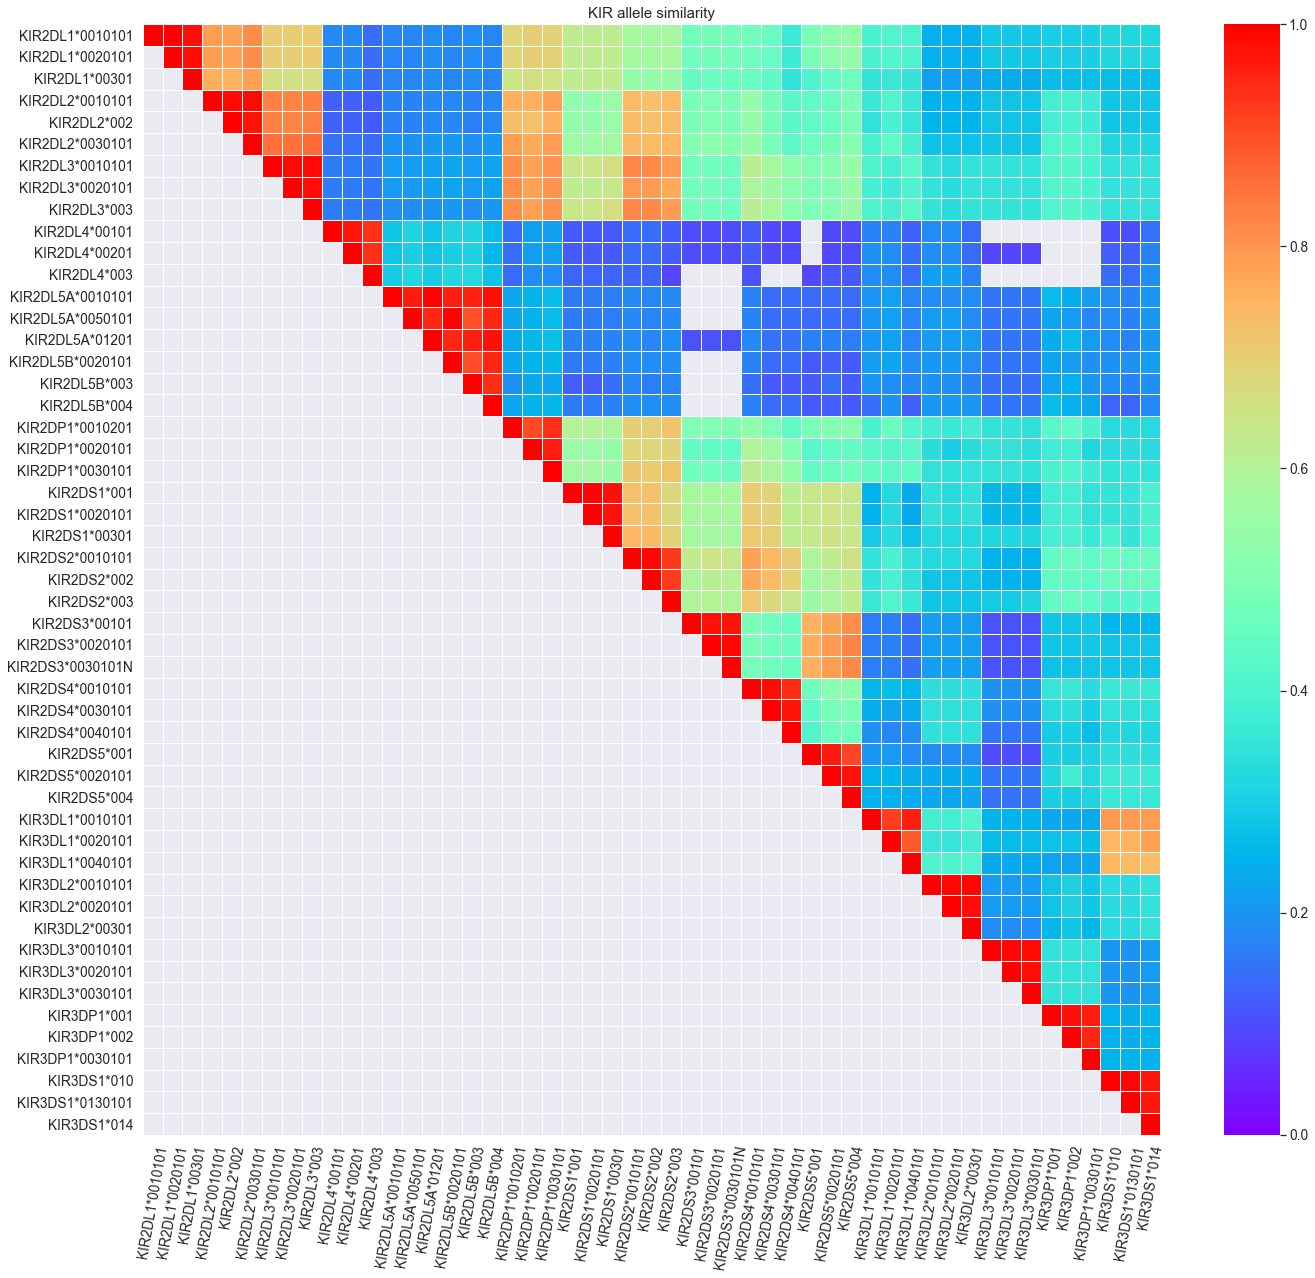

In [157]:
fp = open("data/IPD/kir_rna_rep_sim.tsv")

genev1 = []
genev2 = []
similarityv = []
geneUsed = {}
for line in fp:
    cols = line.rstrip().split()
    genev1.append(cols[0])
    genev2.append(cols[1])
    similarityv.append(float(cols[2]))
    geneUsed[cols[0]] = 1
    geneUsed[cols[1]] = 1
fp.close() 

for g in geneUsed:
    genev1.append(g)
    genev2.append(g)
    similarityv.append(1)

df = pd.DataFrame()
df["Gene A"] = genev1
df["Gene B"] = genev2
df["Similarity"] = similarityv

pivot = df.pivot_table(index="Gene A", columns='Gene B', values="Similarity")
sns.set( font_scale=1.25)
figWidth = 20
figHeight = 18 
fig, axes = plt.subplots( figsize=(figWidth, figHeight ) ) 
snsFig = sns.heatmap( pivot,
                fmt="d", ax = axes, linewidths=0.5, cmap="rainbow", vmax=1, vmin=0 )
snsFig.set( xlabel = "", ylabel="", title="KIR allele similarity" )
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig("IPD_KIR_similarity.png", dpi=300)

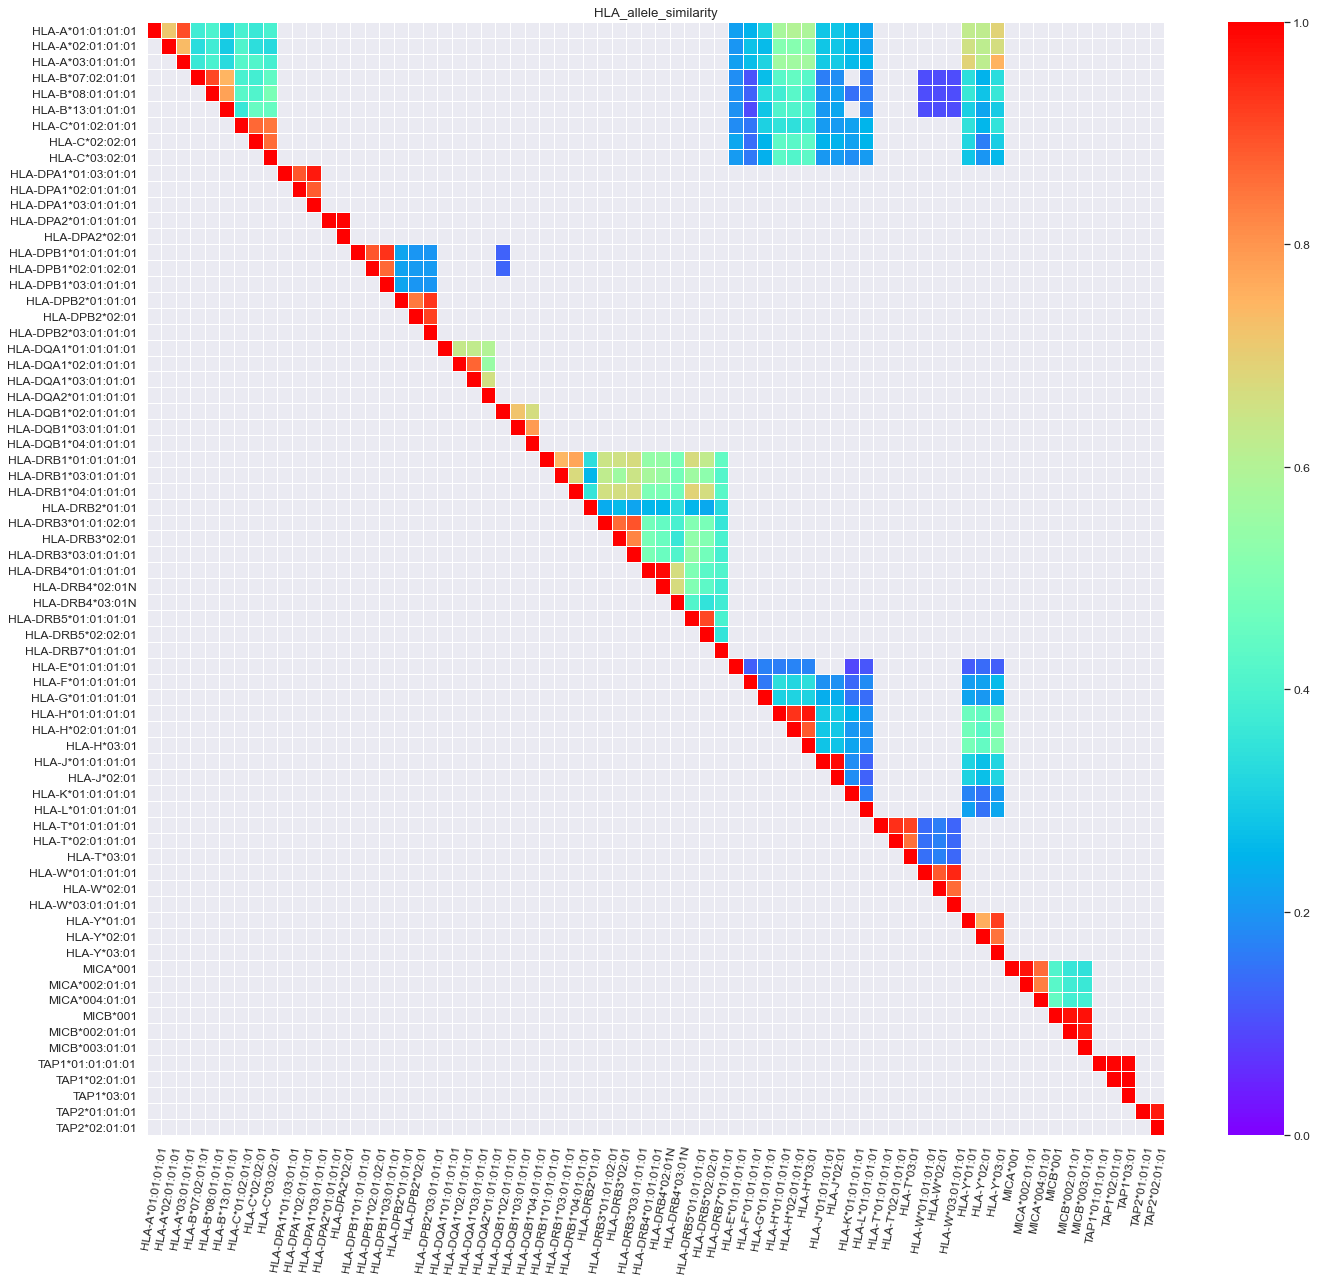

In [9]:
fp = open("data/IPD/hla_rna_rep_sim.tsv")

genev1 = []
genev2 = []
similarityv = []
geneUsed = {}
for line in fp:
    cols = line.rstrip().split()
    genev1.append(cols[0])
    genev2.append(cols[1])
    similarityv.append(float(cols[2]))
    geneUsed[cols[0]] = 1
    geneUsed[cols[1]] = 1
fp.close() 

for g in geneUsed:
    genev1.append(g)
    genev2.append(g)
    similarityv.append(1)

df = pd.DataFrame()
df["Gene A"] = genev1
df["Gene B"] = genev2
df["Similarity"] = similarityv

pivot = df.pivot_table(index="Gene A", columns='Gene B', values="Similarity")
sns.set( font_scale=1.1)
figWidth = 20
figHeight = 18 
fig, axes = plt.subplots( figsize=(figWidth, figHeight ) ) 
snsFig = sns.heatmap( pivot,
                fmt="d", ax = axes, linewidths=0.5, cmap="rainbow", vmax=1, vmin=0 )
snsFig.set( xlabel = "", ylabel="", title="HLA_allele_similarity")
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig("IPD_HLA_similarity.png", dpi=300)
plt.show()